# Calculating the SSHG Yield for a Silicon Surface

## Introduction

Surface second-harmonic generations (SSHG) is an effective, nondestructive, and noninvasive probe for studying surface and interface properties, and even for characterizing buried interfaces and nanostructures. The high surface sensitivity of SSHG spectroscopy is due to the fact that within the dipole approximation, the bulk SHG response in centrosymmetric materials is identically zero. The SHG process can occur only at the surface where the inversion symmetry is broken.

`SHGYield.py` produces the SHG radiation (in reflectance), or yield, produced from a semiconductor surface. This theory is developed considering a reflectance model with three distinct regions that allows the user to readily simulate the SHG response of thin-films over bulk substrates, or of any crystalline surface with any symmetry considerations. Basically, if you are interested in solid-state phyics, nonlinear optics, and surface science, you might find this program useful.

This will be a brief tutorial that explains how the program is written, and how it relates to the math that explains SSHG. For the complete theory, you can find it derived step-by-step in [Phys. Rev. B 94, 115314 (2016)](https://doi.org/10.1103/PhysRevB.94.115314). You can also find a great deal of information in the following publications:

* [Front. Mater. 4:12 (2017)](https://doi.org/10.3389/fmats.2017.00012)
* [Phys. Rev. B 94, 115314 (2016)](https://doi.org/10.1103/PhysRevB.94.115314)
* [Phys. Rev. B 93, 235304 (2016)](https://doi.org/10.1103/PhysRevB.93.235304)
* [Phys. Rev. B 91, 075302 (2015)](https://doi.org/10.1103/PhysRevB.91.075302)
* [arXiv:1604.07722 (2016)](https://arxiv.org/abs/1604.07722)
* [Theoretical Optical Second-Harmonic Calculations for Surfaces (2016)](https://doi.org/10.13140/RG.2.2.35619.66082)


### Before We Start

In order to calculate the SHG yield, you must first calculate the linear and nonlinear susceptibility tensor, $\boldsymbol{\chi}(2\omega)$, for the material of interest. `SHGYield.py` does NOT care how you have produced the susceptibility tensors; you can use different frameworks (such as MBPT, DFT-LDA, TDDFT, etc.) for producing the linear and nonlinear susceptibility tensors. Please refer to the [Appendix](#appendixa) for more information. Fortunately for you, I have already provided all the tensor files necessary for this sample surface.

The code that is included in this tutorial will be slightly different than what is in main `SHGYield.py` file. This is simply because `SHGYield.py` is designed to be run from the command line, with no user interaction outside of the input file. It has several functions and features that are not needed in a short tutorial like this one. However, most of the code below will be very close to the original. For brevity, I will often omit comments and notes from the code below -- the main program is extensively documented so be sure to review it carefully if something is unclear.

I will make constant reference to the [Phys. Rev. B 94, 115314 (2016)](https://doi.org/10.1103/PhysRevB.94.115314) article during this tutorial. As not everyone has access to academic journals, I will include all the relevant equations here with the corresponding equation number from that reference.

## A Practical Example: The SSHG Yield ($\mathcal{R}_{sP}$) for the Si(111)(1x1):H surface

All that being said, it's time to get started! You might be wondering why we are going to study the Si(111)(1x1):H surface? Mainly because:

* There is good experimental reference data available
* We have had good success reproducing said data using this theoretical development
* This particular surface is relevant to semiconductor design and development

You can see a representation of this surface in the following figure,

<img src="figures/diagram.png" width=640/>

where the blue balls are Si atoms and the red balls are H atoms. The figure also presents our three layer reflectance model for calculating the SSHG yield. This model is comprised of three regions:

1. Above the surface lies a vacuum region, with a dielectric function $\epsilon_{v}(\omega)=1$ from where the fundamental electric field impinges on the material.
2. The second layer is a thin layer ($\ell$) of thickness $d$ characterized by a dielectric function $\epsilon_{\ell}(\omega)$, and it is in this layer where the SSHG takes place.
3. The third layer is the bulk region denoted by $b$ and characterized by $\epsilon_{b}(\omega)$.

For our simple example, we will consider that the bulk layer is bulk Si, and our thin surface layer is the Si(111)(1x1):H surface. However, you could just as easily have a different bulk material below the thin layer. This is very much like a real thin-film deposited on a substrate, for instance.

Anyway, let's go ahead and import the necessary Python packages:

In [3]:
import yaml
import numpy as np
from scipy import constants

# These packages are only for displaying plots in this tutorial
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

`numpy` will be our workhorse as we will read the datasets into arrays to be multiplied and manipulated accordingly. `scipy` is handy for certain constants, although you can easily get by without it. YAML is a great choice for inputting our program parameters, so we'll use the `PyYAML` package to parse them correctly.

Since we now have the necessary packages let's go ahead and parse our input parameters! We'll use a very simple set of input parameters for this example

In [4]:
PARAM = yaml.load(r"""
parameters:
    theta:      65       # angle of incidence in degrees
    phi:        30       # azimuthal angle in degrees
multiref:
    thickness:  10       # thickness "d" of the thin layer, in nm
    
chi1:                                      # chi1: linear susceptibility tensor.
    chib: chi1-linear/SiBulk-chi1-xx_yy_zz # path to chib (bulk) file
    chil: chi1-linear/SiH1x1-chi1-xx_yy_zz # path to chil (layered) file
    norm: 1.2659296143                     # normalization of chil
    
chi2:                                      # chi2: nonlinear susceptibility tensor for Si(111)(1x1):H
    xxx: chi2-nonlinear/SiH1x1-chi2-xxx
    xyy: -xxx
    xzz: 0
    xxz: chi2-nonlinear/SiH1x1-chi2-xxz
    yyz: xxz
    yxy: -xxx
    zxx: chi2-nonlinear/SiH1x1-chi2-zxx
    zyy: zxx
    zzz: chi2-nonlinear/SiH1x1-chi2-zzz
""")

Running the above provides us with a dictionary called `PARAM` that uses the parameter names as keys. Let's review the parameters.

* `theta` and `phi` are the angles that define how the incident fields impinges on the material. These can be taken from experimental values, or you can just play around with them to find when your output signal is enhanced.
* `thickness` is the thickness $d$ (in nm) of the thin layer, see figure above. This will be used to compute the multiple reflections that have been included in this theory.
* Under `chi1` we have paths for the linear responses of both the thin and bulk layers. These determine the dielectric functions for each region, $\epsilon_{\ell}(\omega)$ and $\epsilon_{b}(\omega)$ (see figure above).
* Under `chi2` we have paths for the different components of $\chi^{\mathrm{abc}}(2\omega)$. Some of these are paths, while others make reference to another component, while others are 0. Any component not listed is automatically assumed to be 0 as well.

Go ahead and check out the `si111-input.yml` file in this directory for a fully loaded version with tons of comments and notes.


### Angles and Constants

We supplied the angles in degrees in the input parameters, but these should be converted to radians before continuing. This is also an opportune time to define some constants that will be used later on.

In [5]:
THETA0 = np.radians(PARAM['parameters']['theta']) # Converts theta to radians
PHI = np.radians(PARAM['parameters']['phi'])      # Converts phi to radians

HBAR = constants.value("Planck constant over 2 pi in eV s")
PLANCK = constants.value("Planck constant in eV s")
EPS0 = constants.epsilon_0                   # \epsilon_{0} in F/m
LSPEED = constants.c                         # Speed of light in m/s

### Energy Range

It's important to establish our energy range of interest. The length of this array determines how much data is read from the other files. For this example, it is convenient to use an energy range of 0-10 eV, in steps of 0.01 eV. We could read this from the tensor files, but I find it more convenient (and faster) to just generate an array with the appropriate length and steps:

In [6]:
MAXE = 1000 # Upper energy limit, usually 1000 = 10 eV
ONEE = np.linspace(0.01, float(MAXE)/100, MAXE) # 1w energy array, 0.01-10 eV

### Nonlinear Suceptibility Tensors, $\chi^{\mathrm{abc}}(2\omega)$

We should also talk a little about the nonlinear susceptibility tensor. It determines the nonlinear polarizability of a material and is responsible for second-harmonic generation. This relationship is expressed as

$$\mathcal{P}^{\mathrm{a}}(2\omega) = \epsilon_{0}\chi^{\mathrm{abc}}(2\omega)E^{\mathrm{b}}(\omega)E^{\mathrm{c}}(\omega),\qquad(9)$$

where $\chi^{\mathrm{abc}}(2\omega)$ are specific components of $\boldsymbol{\chi}(2\omega)$, and a, b, and c are crystallographic directions that depend on how you orient your crystalline structure. We can see that a material can produce a polarization response in direction a from two incident fields ($E$) in directions b and c, by means of $\chi^{\mathrm{abc}}(2\omega)$.

$\boldsymbol{\chi}(2\omega)$ is a third-rank tensor, and thus has 27 possible components (unique combinations of a, b, and c; for instance, aaa, aab, and so on.). Second-harmonic generation implies that the incoming fields are identical (two photons of equal energy in, one photon of double-energy out) so it is also implied that

$$\chi^{\mathrm{abc}}(2\omega) = \chi^{\mathrm{acb}}(2\omega)$$

for this particular phenomenon. This reduces 9 of the possible combinations, reducing to 18 unique components. It is very convenient to express the crystallographic directions in terms of *x*, *y*, and *z*; therefore, we can express $\boldsymbol{\chi}(2\omega)$ with all 18 components as

$$
\boldsymbol{\chi} = 
\begin{pmatrix}
\chi^{xxx}&\chi^{xyy}&\chi^{xzz} &|& \chi^{xyz}&\chi^{xxz}&\chi^{xxy} \\[3pt]
\chi^{yxx}&\chi^{yyy}&\chi^{yzz} &|& \chi^{yyz}&\chi^{yxz}&\chi^{yxy} \\[3pt]
\chi^{zxx}&\chi^{zyy}&\chi^{zzz} &|& \chi^{zyz}&\chi^{zxz}&\chi^{zxy}
\end{pmatrix}
.
\qquad(45)
$$

I have provided you with a good set of $\chi^{\mathrm{abc}}(2\omega)$ components calculated specifically for this surface. You can find these in the adjoining `chi2-nonlinear/` directory. You'll also notice that all 18 components $\chi^{\mathrm{abc}}(2\omega)$ are included in the `si111-input.yml` file. This means that all symmetry relationships are neglected, and thus the program will read all the components exactly as you have provided them. That said, many crystalline materials have symmetry relations, and these are important for determining $\boldsymbol{\chi}(2\omega)$. A given symmetry can greatly reduce the complexity of the problem by eliminating many of the components. For instance, our Si(111)(1x1):H surface has a (111) cubic symmetry which means that

$$
\boldsymbol{\chi}^{(111)} = 
\begin{pmatrix}
\chi^{xxx}&-\chi^{xxx}&    0      &|&     0     &\chi^{xxz}&     0     \\[3pt]
     0    &      0    &    0      &|& \chi^{xxz}&     0    &-\chi^{xxx}\\[3pt]
\chi^{zxx}& \chi^{zxx}&\chi^{zzz} &|&     0     &     0    &     0
\end{pmatrix}
,
\qquad(46)
$$

which has only 4 independent components. Notice how we represented this above in the input parameters. `xxx` is set to a file path, but `xyy` is set to `-xxx`, as indicated in the second column of the first row. Likewise, `xzz = 0`, as indicated in the third column, etc. I ommitted the remainder of the zero-value components from the input parameters just to reduce clutter. You could just as easily keep them there and set them to 0 and the result would be identical. There are many [articles](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.35.1129) and [books](https://books.google.com/books?id=bdFju3af2FsC) with tables and extensive discussion that describe the form that this tensor should have for a given symmetry.

So, the input parameters tell us that we need to load several files containing the components of the susceptibility tensor. We will read these files and manipulate the data in order for everything to work properly. It is very convenient to use a function to take care of this, and we can do so like this:

In [7]:
def shgload(infile):
    data = np.loadtxt(infile, unpack=True, skiprows=1)
    comp = (data[1] + data[3]) + 1j * (data[2] + data[4])
    chi2 = 1e6 * 1e-24 * comp[:MAXE] # Includes conversion to correct units
    return chi2

This functions tells us a lot about the structure of the chi2 files, and about what the program does with them. If you peak into one of the files, you'll see something like this:

```
#energy1w     1w_re           1w_im           2w_re           2w_im
   0.00000   -0.184361E-04    0.000000E+00    0.315863E-03    0.000000E+00
   0.01000   -0.193528E-04    0.000000E+00    0.331586E-03    0.000000E+00
   0.02000   -0.220146E-04    0.000000E+00    0.377249E-03    0.000000E+00
   0.03000   -0.261820E-04    0.000000E+00    0.448758E-03    0.000000E+00
   0.04000   -0.315265E-04    0.000000E+00    0.540502E-03    0.000000E+00
```

The first column is the $1\omega$ energy, the second column is the real $1\omega$ contribution, the third column is the $1\omega$ imaginary contribution, and the third and fourth columns are the real and imaginary $2\omega$ contributions, respectively. We can see that the `shgload` function reads this file, loads it into a NumPy array, then creates the complex number from the real and imaginary parts, and converts to the appropriate units and scale (m$^{2}$/V). These conversion factors (`1e6 * 1e-24`) are necessary for these particular $\chi^{\mathrm{abc}}(2\omega)$ files that I have provided. You'll need to account for your own units if you are calculating your own! Lastly, the funtion returns a NumPy array of the complex values with the correct length.

We should take advantage of every convenience Python has to offer, so let's create a dictionary with all the $\chi^{\mathrm{abc}}(2\omega)$ components:

In [8]:
CHI2 = {}
CHI2_equiv = {}
all_components = ['xxx', 'xyy', 'xzz', 'xyz', 'xxz', 'xxy',
                  'yxx', 'yyy', 'yzz', 'yyz', 'yxz', 'yxy',
                  'zxx', 'zyy', 'zzz', 'zyz', 'zxz', 'zxy']

for component in all_components:
    if component in PARAM['chi2']:       # only components listed in the input parameters
        value = PARAM['chi2'][component]
        try:                             # if it can load the path, then it will
            shg = shgload(value)
        except (ValueError, OSError, IOError):
            if value == 0:               # if it can't, checks to see if component is 0
                shg = 0
            else:                        # if not a path and not 0, must be an equivalence: add to a new dictionary
                CHI2_equiv[component] = value
                continue
    elif component not in PARAM['chi2']: # if not in the input parameters, then must be 0
        shg = 0
    CHI2[component] = shg
    
for key, value in CHI2_equiv.items():
    equivalence = value.split('-')       # equivalences can either have a minus sign or not
    if equivalence[0]:                   # if there is no minus sign, then component_new = component_old
        CHI2[key] = CHI2[equivalence[0]]
    elif not equivalence[0]:             # if there is a minus sign, then component_new = -component_old
        CHI2[key] = -1 * CHI2[equivalence[1]]

After all that, we finally have a dictionary, `CHI2`, with the component names as keys, and with the component data as values. Remember that this data will either be loaded from file (using the `shgload` function), be obtained by relation to another component (an equivalence), or will be 0. Therefore, this dictionary always has all 18 components in it even if many of them might be 0.


### Linear Susceptibility Tensors, $\chi^{\mathrm{ab}}(\omega)$

The case for $\chi^{\mathrm{ab}}(\omega)$ is considerable simpler. $\chi^{\mathrm{ab}}(\omega)$ is directly related to the dielectric function of the material

$$\epsilon^{\mathrm{ab}}(\omega) = 1 + 4\pi\chi^{\mathrm{ab}}(\omega),$$

and

$$\epsilon(\omega) = \frac{1}{3}\bigg[\epsilon^{xx} + \epsilon^{yy} + \epsilon^{zz}\bigg].$$

The $\chi^{\mathrm{ab}}(\omega)$ spectra should obviously have non-zero regions; otherwise, the problem is not very interesting. As before, it's handy to create a simple function to load this file and manipulate the data:

In [9]:
def epsload(in_file, norm):
    data = np.loadtxt(in_file, unpack=True, skiprows=1)
    real = (data[1] + data[3] + data[5])/3      # real average
    imag = (data[2] + data[4] + data[6])/3      # imag average
    coma = real + 1j * imag                     # complex average
    epsa = 1 + (4 * np.pi * coma * norm)        # epsilon with normalization
    return epsa

This function automatically handles the conversion from $\chi^{\mathrm{ab}}(\omega)$ to $\epsilon(\omega)$ according to the equations above. Take a peak into either of the `chi1` files, and you'll find something like:

```
#energy1w     xx_re           xx_im           yy_re           yy_im           zz_re           zz_im
   0.00000    0.886552E+00    0.000000E+00    0.886552E+00    0.000000E+00    0.886552E+00    0.000000E+00
   0.01000    0.886557E+00    0.000000E+00    0.886557E+00    0.000000E+00    0.886557E+00    0.000000E+00
   0.02000    0.886570E+00    0.000000E+00    0.886570E+00    0.000000E+00    0.886570E+00    0.000000E+00
   0.03000    0.886592E+00    0.000000E+00    0.886592E+00    0.000000E+00    0.886592E+00    0.000000E+00
   0.04000    0.886624E+00    0.000000E+00    0.886624E+00    0.000000E+00    0.886624E+00    0.000000E+00
```

The first column is the $1\omega$ energy, the second and third columns are the real and imaginary parts of the xx component, and so on. Many codes will go ahead and calculate $\epsilon(\omega)$ for you -- if this is the case, you can easily modify this function to read it directy and forego the conversion. You can read more information about the normalization of $\chi^{\mathrm{ab}}(\omega)$ in [PRB 92, 245308 (2015)](https://doi.org/10.1103/PhysRevB.92.245308). The short version is that the layered dielectric function $\epsilon_{\ell}$ should be normalized, while the bulk dielectric function $\epsilon_{b}$ should not. This normalization value is obtained from our input parameters above.

Anyway, all that remains is creating new NumPy arrays with each dielectric function. We'll need to do this for $1\omega$ and $2\omega$ values, so we can do something like this:

In [10]:
CHI1NORM = PARAM['chi1']['norm']                # Normalization for layered chi1
epsb = epsload(PARAM['chi1']['chib'], 1)        # Epsilon from chi1, bulk
epsl = epsload(PARAM['chi1']['chil'], CHI1NORM) # Epsilon from chi1, layered, normalized

epsv1w = 1                              # Epsilon for vacuum = 1
epsv2w = 1                              # Epsilon for vacuum = 1
epsb1w = epsb[:MAXE]                    # Epsilon for bulk, 1w
epsb2w = epsb[1::2][:MAXE]              # Epsilon for bulk, 2w
epsl1w = epsl[:MAXE]                    # Epsilon for layer, 1w
epsl2w = epsl[1::2][:MAXE]              # Epsilon for layer, 2w

So, now we have $\epsilon_{v}(\omega) = 1$, $\epsilon_{v}(2\omega) = 1$, $\epsilon_{\ell}(\omega)$, $\epsilon_{\ell}(2\omega)$, $\epsilon_{b}(\omega)$, and $\epsilon_{b}(2\omega)$. All these will be used quite a bit in the upcoming sections. Let's plot the bulk and layer dielectric functions:

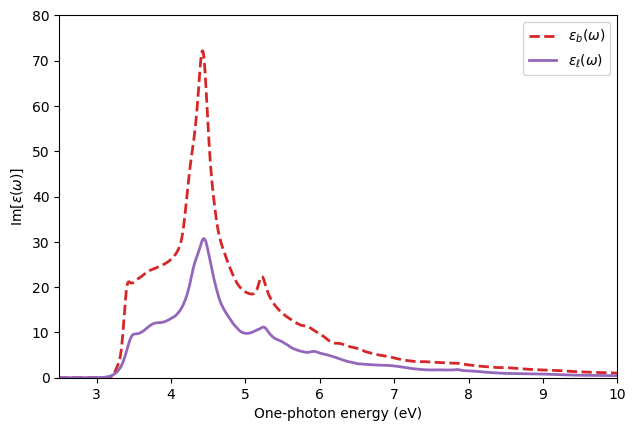

In [11]:
fig, axes = plt.subplots(figsize=(7.2,4.8), dpi=100)

axes.plot(ONEE, epsb1w.imag, 'C3--', label=r'$\epsilon_{b}(\omega)$', lw=2)
axes.plot(ONEE, epsl1w.imag, 'C4', label=r'$\epsilon_{\ell}(\omega)$', lw=2)

axes.set_xlabel('One-photon energy (eV)')
axes.set_ylabel(r'Im$[\epsilon(\omega)]$')
axes.set_xlim([2.5, 10])
axes.set_ylim([0, 80])
axes.legend();

It's interesting to see how both dielectric functions are quite similar in shape, but different in intensity. If we considered a much thicker layer, with many more atomic layers, these two would become very close.

We can go ahead and calculate the index of refraction as $n(\omega) = \sqrt{\epsilon(\omega)}$. We'll only need these for the thin layer ($\ell$):

In [12]:
## Indices of refraction for 1w (n) and 2w (N), where n = sqrt{epsilon}
nl1w = np.sqrt(epsl1w) # Index of refraction for thin layer, 1w
nl2w = np.sqrt(epsl2w) # Index of refraction for thin layer, 2w

At this point we have finished loading the files and creating the arrays for both the nonlinear and linear responses. The $\chi^{\mathrm{abc}}(2\omega)$ components have been stored in a dictionary, and we have 6 arrays with the $1\omega$ and $2\omega$ dielectric functions for each of the three regions in our model. Everything after this point will be calculated using these quantities.

**
For simplicity, we will only be calculating one particular polarization combination for the SSHG yield: $\mathcal{R}_{sP}$. This implies that we have $1\omega$ incident fields in $s$ polarization, and outgoing $2\omega$ second-harmonic radiation in $P$ polarization.
**

### Wave Vectors

The so-called wave vector is a quantity that will pop-up often in our theoretical development. We define it for each region as

$$
w^{\phantom{a}}_{\beta}(\omega) = 
\big[\epsilon^{\phantom{a}}_{\beta}(\omega) - \sin^{2}\theta_{0}\big]^{1/2},
\qquad(6)
$$

where $\beta$ can be either $v$ for the vacuum, $\ell$ for the thin layer, or $b$ for the bulk. Let's go ahead and code these for each region at $1\omega$ and $2\omega$:

In [13]:
wv1w = np.sqrt(epsv1w - (np.sin(THETA0)**2)) # Wave vector for vacuum, 1w
wv2w = np.sqrt(epsv2w - (np.sin(THETA0)**2)) # Wave vector for vacuum, 2w
wb1w = np.sqrt(epsb1w - (np.sin(THETA0)**2)) # Wave vector for bulk, 1w
wb2w = np.sqrt(epsb2w - (np.sin(THETA0)**2)) # Wave vector for bulk, 2w
wl1w = np.sqrt(epsl1w - (np.sin(THETA0)**2)) # Wave vector for layer, 1w
wl2w = np.sqrt(epsl2w - (np.sin(THETA0)**2)) # Wave vector for layer, 2w

### Fresnel Factors

Let's review our three layer model once again. For the radiated second-harmonic ($2\omega$), our model looks like the following figure.

<img src="figures/2w.png" width=640/>

Likewise, we have something like this for the incoming fundamental ($1\omega$) fields.

<img src="figures/1w.png" width=514/>

The Fresnel factors dictate how the fields will interact at the interfaces. There are two interfaces: the $v\ell$ interface which is between vacuum and the thin layer, and the $\ell b$ interface that occurs between the thin layer and the bulk of the material. We should start with the most "generic" Fresnel factors. For reflections, these are

$$
\begin{split}
r_{s}^{ij}(\omega) &=
\frac{w_{i}(\omega) - w_{j}(\omega)}
     {w_{i}(\omega) + w_{j}(\omega)},\\
r_{p}^{ij}(\omega) &=
\frac{w_{i}(\omega)\epsilon_{j}(\omega) - w_{j}\epsilon_{i}(\omega)}
     {w_{i}(\omega)\epsilon_{j}(\omega) + w_{j}(\omega)\epsilon_{i}(\omega)}
\end{split}
$$

where $ij$ can be either the $vl$ or $lb$, and $s$ and $p$ represent the polarization. It is convenient to code these as a function:

In [14]:
def freflc(pol, veci, vecj, epsi, epsj): # reflection fresnel factors
    if pol == "p":
        factor = ((veci * epsj) - (vecj * epsi))/((veci * epsj) + (vecj * epsi))
    elif pol == "s":
        factor = (veci - vecj)/(veci + vecj)
    return factor

Likewise, the transmission Fresnel factors are

$$
\begin{split}
t_{s}^{ij}(\omega) &=
\frac{2w_{i}(\omega)}{w_{i}(\omega) + w_{j}(\omega)},\\
t_{p}^{ij}(\omega) &=
\frac{2w_{i}(\omega)\sqrt{\epsilon_{i}(\omega)\epsilon_j(\omega)}}
     {w_{i}(\omega)\epsilon_{j}(\omega) + w_{j}(\omega)\epsilon_{i}(\omega)}
\end{split},
$$

and coding these in a function:

In [15]:
def ftrans(pol, veci, vecj, epsi, epsj): # transmission fresnel factors
    if pol == "p":
        factor = (2 * veci * np.sqrt(epsi * epsj))/(veci * epsj + vecj * epsi)
    elif pol == "s":
        factor = (2 * veci)/(veci + vecj)
    return factor

With these functions in place, we can now code the necessary Fresnel factors for each polarization ($s$ and $p$), for each interface ($vl$ and $lb$), at both $1\omega$ (lowercase) and $2\omega$ (uppercase):

In [16]:
## Fresnel factors for 1w and 2w, s and p polarizations. See Eqs. (13) and (14)
## of PRB 94, 115314 (2016).
tvls = ftrans("s", wv1w, wl1w, epsv1w, epsl1w) # Transmission, 1w, vacuum-layer, s
Tvlp = ftrans("p", wv2w, wl2w, epsv2w, epsl2w) # Transmission, 2w, vacuum-layer, p

rvls = freflc("s", wv1w, wl1w, epsv1w, epsl1w) # Reflection,   1w, vacuum-layer, s
rlbs = freflc("s", wl1w, wb1w, epsl1w, epsb1w) # Reflection,   1w, layer-bulk,   s
Rvlp = freflc("p", wv2w, wl2w, epsv2w, epsl2w) # Reflection,   2w, vacuum-layer, p
Rlbp = freflc("p", wl2w, wb2w, epsl2w, epsb2w) # Reflection,   2w, layer-bulk,   p

This produces the $t^{vl}_{s}$, $T^{vl}_{p}$, $r^{vl}_{s}$, $r^{lb}_{s}$, $R^{vl}_{p}$, and $R^{lb}_{p}$ Fresnel factors. Note that there are more combinations, but these are the only ones necessary for calculating the $\mathcal{R}_{sP}$ SSHG yield.


### Multiple Reflections

One of the new-fangled features of this development is the addition of the effects from multiple reflections. See the two figures above for a representation of this. Anyway, we solve this by introducing two quantities that represent the phase difference between each reflection:

$$
\delta = 8\pi\left(\frac{d}{\lambda_{0}}\right)W_{\ell},\qquad(17)
$$

for the $2\omega$ second-harmonic radiation, and

$$
\varphi = 4\pi\left(\frac{d}{\lambda_{0}}\right)w_{\ell},\qquad(23)
$$

for the $1\omega$ incident fields. $d$ is the thickness of the thin layer (read from the input parameters, remember?), $\lambda_{0}$ is the wavelength of the fundamental field in the vacuum, and $W_{\ell}$ ($w_{\ell}$) is the $2\omega$ ($1\omega$) wave vector, established above. Both of these can be easily coded:

In [17]:
thickness = PARAM['multiref']['thickness'] # Thickness d of the thin layer \ell

delta = 8 * np.pi * ((ONEE * thickness * 1e-9)/(PLANCK * LSPEED)) * wl2w
varphi = 4 * np.pi * ((ONEE * thickness * 1e-9)/(PLANCK * LSPEED)) * wl1w

After some algebra which I will not include here, we can obtain reflection Fresnel factors that take into account the multiple reflections. For the $2\omega$, $p$-polarized second-harmonic radiation, we have

$$
\begin{split}
R^{M}_{p} \equiv
\frac{R^{\ell b}_{p}e^{i\delta/2}}
{1 + R^{v\ell}_{p}R^{\ell b}_{p}e^{i\delta}}
\,\mathrm{sinc}(\delta/2)
\end{split},\qquad(22)
$$

and

$$
R^{M\pm}_{p} = 1 \pm R^{M}_{p},\qquad(31)
$$

which can both be readily coded:

In [18]:
RMp = (Rlbp * np.exp(1j * delta/2))/(1 + (Rvlp * Rlbp * np.exp(1j * delta))) * np.sin(delta/2)/(delta/2)
RMplusp = 1 + RMp
RMminusp = 1 - RMp

Likewise for the $1\omega$, $s$-polarized incident fields, we have

$$
r^{M}_{s} \equiv
\frac{r^{\ell b}_{s}e^{i\varphi}}{1+r^{v\ell}_{s}
r^{\ell b}_{s}e^{i\varphi}},\qquad(26)
$$

and

$$
r^{M+}_{s} = 1 + r^{M}_{s}.\qquad(30)
$$

Again, these are readily coded:

In [19]:
rMs = (rlbs * np.exp(1j * varphi))/(1 + (rvls * rlbs * np.exp(1j * varphi)))
rMpluss = 1 + rMs

### Putting It All Together!

At long last, we finally have almost everything needed to complete our calculation. I will exclude a lot of the algebra that models how the light propogates within the material. This is what ties in the Fresnel factors and the multiple reflections with the nonlinear polarization (the very first equation, way up there). You can check out the [article](https://doi.org/10.1103/PhysRevB.94.115314) for that math. We can split up the end result into two factors,

$$
\Gamma_{sP}=
\frac{T^{v\ell}_{p}}{N_{\ell}}
\left(t^{v\ell}_{s}r^{M+}_{s}\right)^{2},\qquad(54)
$$

and

$$
r_{sP} =
\begin{pmatrix}
-R^{M-}_{p}W_{\ell}\cos\phi \\[3pt]
-R^{M-}_{p}W_{\ell}\sin\phi \\[3pt]
+R^{M+}_{p}\sin\theta_{0}
\end{pmatrix}
\circ
\boldsymbol{\chi}
\cdot
\begin{pmatrix}
\sin^{2}\phi\\
\cos^{2}\phi\\
0\\
0\\
0\\
- 2\sin\phi\cos\phi
\end{pmatrix}
.\qquad(55)
$$

Coding them is, as always, quite straightforward:

In [20]:
GammasP = (Tvlp/nl2w) * (tvls * rMpluss)**2

rsP = - (RMminusp * wl2w * np.sin(PHI)**2 * np.cos(PHI) * CHI2['xxx']) \
      + (RMminusp * wl2w * 2 * np.sin(PHI) * np.cos(PHI)**2 * CHI2['xxy']) \
      - (RMminusp * wl2w * np.cos(PHI)**3 * CHI2['xyy']) \
      - (RMminusp * wl2w * np.sin(PHI)**3 * CHI2['yxx']) \
      + (RMminusp * wl2w * 2 * np.sin(PHI)**2 * np.cos(PHI) * CHI2['yxy']) \
      - (RMminusp * wl2w * np.sin(PHI) * np.cos(PHI)**2 * CHI2['yyy']) \
      + (RMplusp * np.sin(THETA0) * np.sin(PHI)**2 * CHI2['zxx']) \
      - (RMplusp * np.sin(THETA0) * 2 * np.sin(PHI) * np.cos(PHI) * CHI2['zxy']) \
      + (RMplusp * np.sin(THETA0) * np.cos(PHI)**2 * CHI2['zyy'])

Notice that we finally get to use our `CHI2` dictionary for the first time. Recall that the (111) surface has some symmetry relationships that will eliminate or reduce many of the components. The avid reader can confirm that this large expression reduces to

$$
r^{(111)}_{sP} = 
R^{M+}_{p}\sin\theta_{0}\chi^{zxx} +
R^{M-}_{p}W_{\ell}\chi^{xxx}\cos3\phi,\qquad(56)
$$

for this particular surface. However, we specified our symmetry relations in our input parameters so there is no need to do any extra math -- the program knows what value each component should have.

Finally, we can calculate the final SSHG Yield as

$$
\mathcal{R}_{sP}(2\omega) =
\frac{\omega^{2}}{2\epsilon_{0}c^3\cos^{2}\theta_{0}}
\left\vert  \frac{1}{n_{\ell}}\Gamma_{sP}\,r_{sP}\right\vert^{2},\qquad(28)
$$

which we will code to be in the correct scale and units of $10^{-20}\times\mathrm{cm}^{2}/\mathrm{W}$:

In [21]:
PREFACTOR = 1/(2 * EPS0 * HBAR**2 * LSPEED**3 * np.cos(THETA0)**2)
RsP = 1e20 * 1e4 * PREFACTOR * (ONEE ** 2) * np.absolute((1/nl1w) * GammasP * rsP)**2

We deserve a reward after all this work, so let's take a peak at what the SSHG yield looks like. A two-photon energy between 2.5 and 5 eV is enough to cover both the $E_{1} \sim 3.4$ eV and $E_{2} \sim 4.3$ eV critical points of bulk Si.

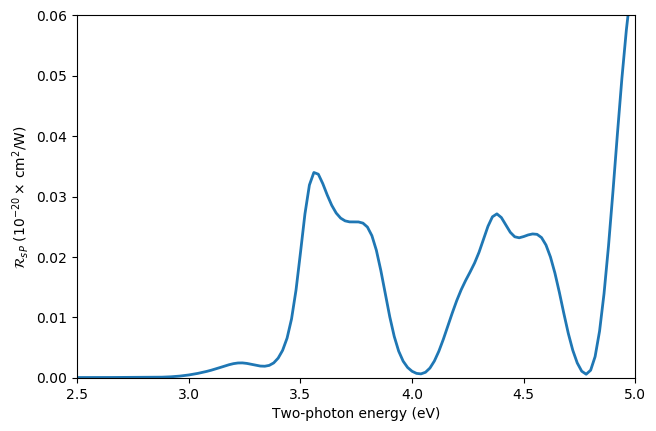

In [24]:
fig, axes = plt.subplots(figsize=(7.2,4.8), dpi=100)

axes.plot(2*ONEE, RsP, lw=2)
axes.set_xlabel('Two-photon energy (eV)')
axes.set_ylabel(r'$\mathcal{R}_{sP}\,\,(10^{-20}\times\,\mathrm{cm}^{2}/\mathrm{W})$')
axes.set_xlim([2.5, 5])
axes.set_ylim([0, 0.06]);

This concludes this tutorial for calculation the SSHG yield, $\mathcal{R}_{pS}$, for the Si(111)(1x1):H surface. I hope that it helps clarify some of the concepts behind the physics and the software. Please check out the main program file for the complete code with lots of additional comments and notes.

## Appendix: Calculating the Susceptibility Tensors
<a id='appendixa'></a>

The theory concerning the calculation of the susceptibility tensors is still being developed, and there are many ways to go about it. We leave it to the reader to find the best method for their particular problem. As an example, we use [ABINIT](http://www.abinit.org) to calculate the electron density/wavefunction/energies and then [TINIBA](https://github.com/bemese/tiniba) to calculate the relevant matrix elements and the $\boldsymbol{\chi}(2\omega)$ tensor components. The exact method that we use is derived in full detail in [Phys. Rev. B 91, 075302 (2015)](https://doi.org/10.1103/PhysRevB.91.075302).

The exact method that we use to calculate $\boldsymbol{\chi}(2\omega)$ is derived in full detail in [Phys. Rev. B 91, 075302 (2015)](https://doi.org/10.1103/PhysRevB.91.075302). The relevant equations from that article, Eqs. (28a-28d), are as follows:

$$
\mathrm{Im}[\chi^{\mathrm{a}\mathrm{b}\mathrm{c}}_{e,\omega}]= 
\frac{\pi |e|^3}{2\hbar^2}
\int \frac{d^{3}k}{8\pi^3}
\sum_{vc}\sum_{q\neq(v,c)}\frac{1}{\omega^\Sigma_{cv}}
\left[
\frac{\mathrm{Im}[\mathcal{V}^{\Sigma,\mathrm{a}}_{qc}
\{r^{\mathrm{b}}_{cv}r^{\mathrm{c}}_{vq}\}]}
{(2\omega^\Sigma_{cv}-\omega^\Sigma_{cq})} 
-\frac{\mathrm{Im}[\mathcal{V}^{\Sigma,\mathrm{a}}_{vq}
\{r^{\mathrm{c}}_{qc}r^{\mathrm{b}}_{cv}\}]}
{(2\omega^\Sigma_{cv}-\omega^\Sigma_{qv})}
\right]\delta(\omega^\Sigma_{cv}-\omega),
$$

$$
\mathrm{Im}[\chi^{\mathrm{a}\mathrm{b}\mathrm{c}}_{i,\omega}]= 
\frac{\pi\vert e\vert^3}{2\hbar^2}
\int \frac{d^{3}k}{8\pi^3}
\sum_{cv}\frac{1}{(\omega^\Sigma_{cv})^{2}}
\left[
\mathrm{Re}\left[\left\{r^{\mathrm{b}}_{cv}
\left(\mathcal{V}^{\Sigma,\mathrm{a}}_{vc}\right)_{;k^{\mathrm{c}}}\right\}
\right]
+\frac{\mathrm{Re}\left[\mathcal{V}^{\Sigma,\mathrm{a}}_{vc}
\left\{r^{\mathrm{b}}_{cv}\Delta^{\mathrm{c}}_{cv}\right\}
\right]}{\omega^\Sigma_{cv}} 
\right]\delta(\omega^\Sigma_{cv}-\omega),
$$

$$
\mathrm{Im}[\chi^{\mathrm{a}\mathrm{b}\mathrm{c}}_{e,2\omega}]= 
-\frac{\pi |e|^3}{2\hbar^2}
\int \frac{d^{3}k}{8\pi^3}
\sum_{vc}\frac{4}{\omega^\Sigma_{cv}}
\left[
\sum_{v'\ne
  v}\frac{\mathrm{Im}[\mathcal{V}^{\Sigma,\mathrm{a}}_{vc}
  \{r^{\mathrm{b}}_{cv'}r^{\mathrm{c}}_{v'v}\}]}
{2\omega^\Sigma_{cv'}-\omega^\Sigma_{cv}}
- \sum_{c'\ne
  c}\frac{\mathrm{Im}[\mathcal{V}^{\Sigma,\mathrm{a}}_{vc}
  \{r^{\mathrm{c}}_{cc'}r^{\mathrm{b}}_{c'v}\}]}
{2\omega^\Sigma_{c'v}-\omega^\Sigma_{cv}}
\right]\delta(\omega^\Sigma_{cv}-2\omega),
$$

$$
\mathrm{Im}[\chi^{\mathrm{a}\mathrm{b}\mathrm{c}}_{i,2\omega}]= 
 \frac{\pi \vert
   e\vert^{3}}{2\hbar^2}
\int \frac{d^{3}k}{8\pi^3}
\sum_{vc}\frac{4}{(\omega^\Sigma_{cv})^{2}}
\left[\mathrm{Re}\left[\mathcal{V}^{\Sigma,\mathrm{a}}_{vc}
\left\{\left(r^{\mathrm{b}}_{cv}\right)_{;k^{\mathrm{c}}}
\right\}\right] -
\frac{2\mathrm{Re}\left[\mathcal{V}^{\Sigma,\mathrm{a}}_{vc}
\left\{r^{\mathrm{b}}_{cv}\Delta^{\mathrm{c}}_{cv}\right\}\right]}
{\omega^\Sigma_{cv}}\right]\delta(\omega^\Sigma_{cv}-2\omega),
$$

where we have split the interband and intraband $1\omega$ and $2\omega$ contributions and suppressed the $\omega$ arguments for convenience of notation. The real part of each contribution can be obtained through a Kramers-Kronig transformation and $\chi^{\mathrm{a}\mathrm{b}\mathrm{c}}= \chi^{\mathrm{a}\mathrm{b}\mathrm{c}}_{e,\omega} +\chi^{\mathrm{a}\mathrm{b}\mathrm{c}}_{e,2\omega} +\chi^{\mathrm{a}\mathrm{b}\mathrm{c}}_{i,\omega} +\chi^{\mathrm{a}\mathrm{b}\mathrm{c}}_{i,2\omega}$.


### Calculating the electronic properties of semiconductors

In general, there are several *ab initio* formalisms that can be used to obtain the electron density/wavefunction/energies of crystalline semiconductor materials. The most common are:

* all-electron methods (older, declining in popularity)
* density functional theory with the local-density approximation (DFT-LDA) (solid workhorse with known problems)
* time-dependent density functional theory (TDDFT) (good for optical responses, but hard to implement)
* many-body perturbation theory (MBPT) (state-of-the-art, but extreme computational expense)

Each of these has their pros and cons that mainly relate to accuracy vs. difficulty of the theory vs. computer resources. There are [many free and open-source codes](http://psi-k.net/software/) available for download that are under active development by thousands of researchers and groups.


### Calculating the susceptibility tensors and optical properties

Once the initial electronic properties of the material are determined, we can then proceed to calculate the optical properties that include the linear and nonlinear responses. In general, nonlinear optics is now pretty well understood within the DFT-LDA (see references within [Phys. Rev. B 91, 075302 (2015)](https://doi.org/10.1103/PhysRevB.91.075302)) and the [TDDFT](http://dx.doi.org/10.1063/1.2790014) frameworks. MBPT is currently (AFAIK) still at the linear optics level, but has the highest level of accuracy available. Of course, you can combine different methods to exploit the strengths that each has to offer. 

The code that we use is called [TINIBA](https://github.com/roguephysicist/tiniba); however, we have not yet created an official release for production use. That said, we are an active research group that uses this software every day to produce high-quality scientific work, and are constantly improving and adding features to it. Publishing TINIBA is definitely a long-term goal that we have.

There are, however, some codes available, such as [RT-SIESTA](http://monalisa.phys.washington.edu/feffproject-rtsiesta.html) which works with TDDFT, and even [ABINIT](http://www.abinit.org/doc/helpfiles/for-v8.2/users/optic_help.html) has built-in utilities for calculating the susceptibility tensors.